In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u

from gw_signal_tools import latexparams
from gw_signal_tools.waveform import (
    get_wf_generator, WaveformDerivative
)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

In [3]:
f_min = 20.*u.Hz
f_max = 1024.*u.Hz

wf_params = {
    # 'total_mass': 100.*u.solMass,
    # 'total_mass': 50.*u.solMass,
    # 'chirp_mass': 50.*u.solMass,
    'chirp_mass': 30.*u.solMass,
    'mass_ratio': 0.42*u.dimensionless_unscaled,
    'deltaT': 1./2048.*u.s,
    'f22_start': f_min,
    # 'deltaF': 2**-10*u.Hz,
    'deltaF': 2**-8*u.Hz,
    'f_max': f_max,
    'f22_ref': 20.*u.Hz,
    'phi_ref': 0.*u.rad,
    # 'distance': 1.*u.Mpc,
    'distance': 440.*u.Mpc,
    'inclination': 0.0*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    # 'spin1z': 0.42*u.dimensionless_unscaled,
    'condition': 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
wf_generator = get_wf_generator(approximant)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


# Derivative Testing

In [4]:
# param_to_vary = 'total_mass'
param_to_vary = 'chirp_mass'
# param_to_vary = 'sym_mass_ratio'
# param_to_vary = 'mass_ratio'
# param_to_vary = 'distance'
# param_to_vary = 'spin1z'

* total_mass: very good agreement, 1e-6 relative difference for lower frequencies and not more than 1e-3 overall -> gets worse, 1e-2 for larger frequencies; is perhaps due to large influence of total mass on phase; this is what it looks like for 100 Msun, for 50 Msun things are one to two orders of magnitude below these numbers
* chirp_mass: agreement is good, relative error of around 1e-3 until values get close to zero
* sym_mass_ratio: not perfect for 0.05, but this is very challenging territory
* mass_ratio: pretty good, relative differences are never larger than 1e-4 until $\approx 60 Hz$; larger for higher frequencies, but numdifftools error increases there drastically as well, which means this might not come from our implementation
* distance: really good for mass ratio 0.42 (1e-9 relative error), but for 0.5 it is not good, phases seem to differ quite a bit

In [5]:
deriv_gw_signal = WaveformDerivative(
    wf_params,
    param_to_vary,
    wf_generator,
    convergence_check='diff_norm',
    # convergence_threshold=0.005,
    # convergence_threshold=0.0001,  # Testing if relative difference becomes smaller when doing this -> yes it does; but computation time also increases significantly
    # start_step_size=1e-3,
    # start_step_size=1e-8,  # For fun
    deriv_routine='gw_signal_tools'
)

num_deriv_gw_signal, info_dict_gw_signal = deriv_gw_signal(), deriv_gw_signal.deriv_info

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

In [6]:
info_dict_gw_signal

{'norm_squared': <Quantity 9.13607631e-43 1 / solMass2>,
 'final_step_size': 0.0005,
 'final_convergence_val': <Quantity 0.00018878>,
 'number_of_refinements': 0,
 'final_set_of_step_sizes': array([1.e-02, 5.e-03, 1.e-03, 5.e-04, 1.e-04, 5.e-05, 1.e-05,
        5.e-06, 1.e-06]),
 'deriv_formula': 'five_point'}

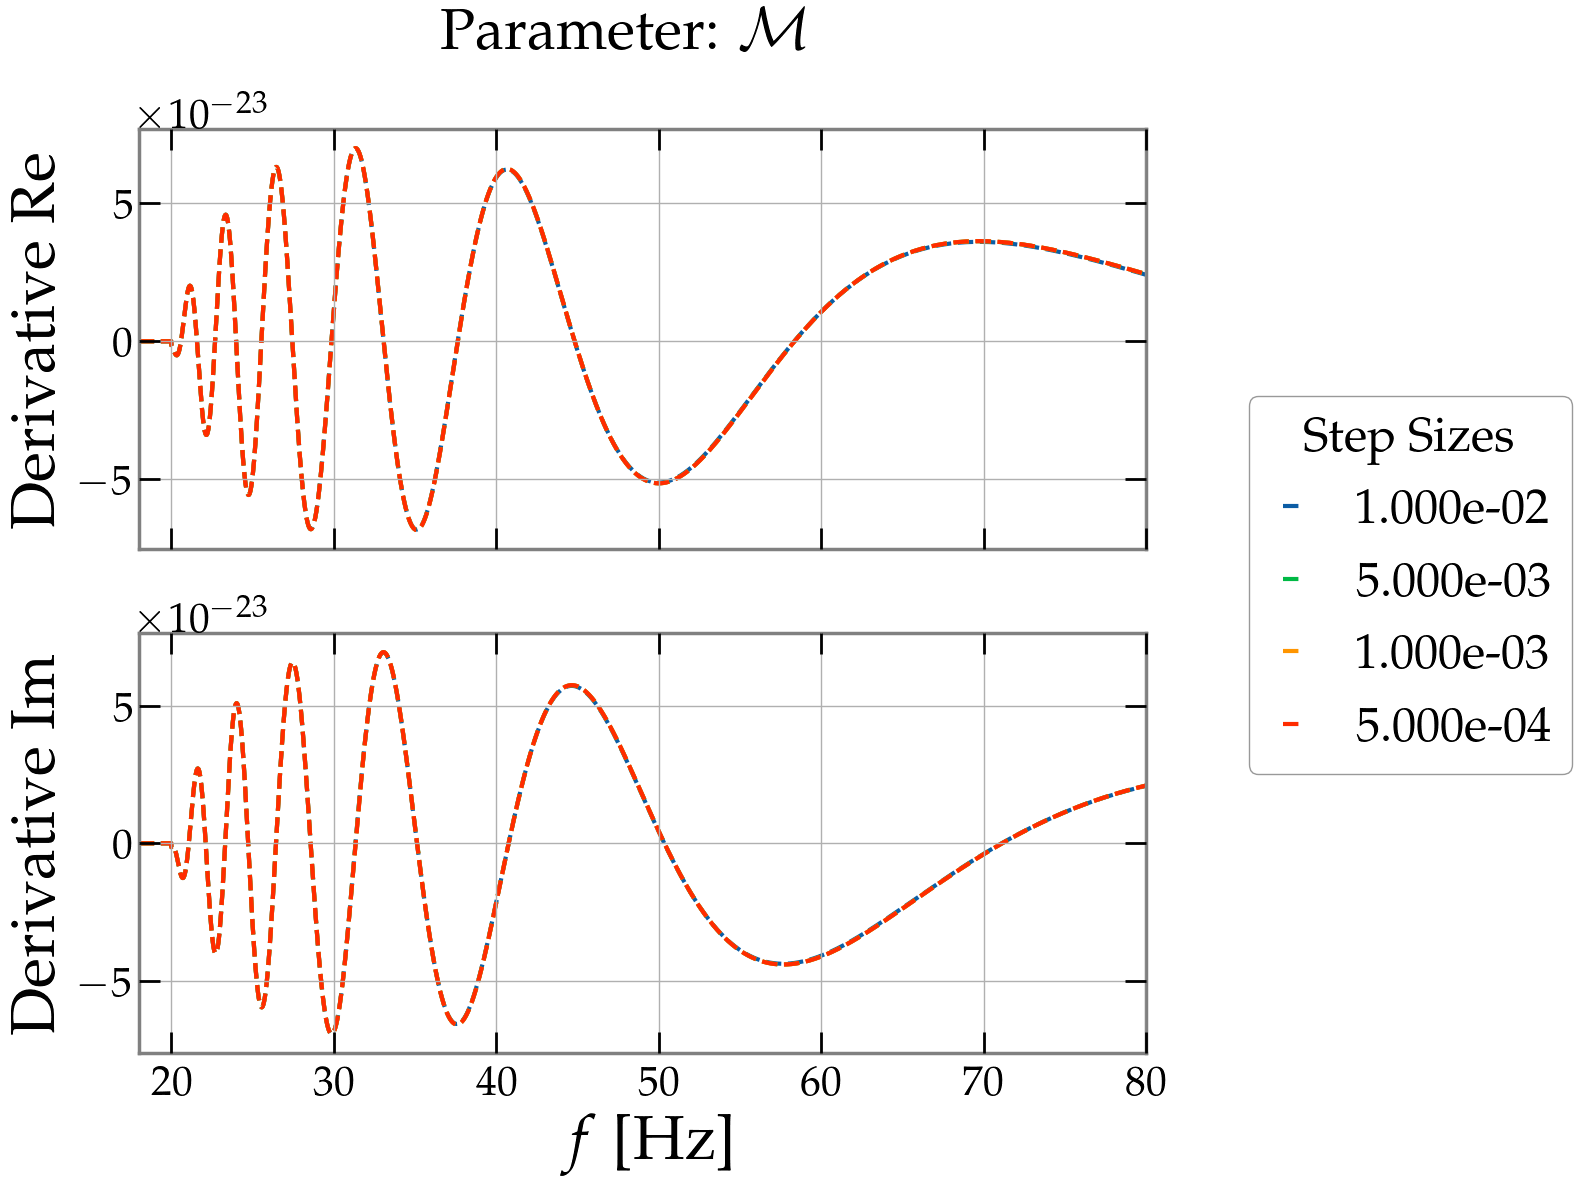

In [7]:
ax = deriv_gw_signal.convergence_plot()

plt.xlim([18, 80])

plt.show()

Convergence/stability is demonstrated here very well

In [9]:
deriv_nd_tools = WaveformDerivative(
    wf_params,
    param_to_vary,
    wf_generator,
    deriv_routine='numdifftools'
)

num_deriv_nd_tools, info_dict_nd_tools = deriv_nd_tools(), deriv_nd_tools.deriv_info

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

In [10]:
info_dict_nd_tools

{'f_value': <FrequencySeries([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j,
                   0.+0.j]
                  unit=Unit("s"),
                  f0=<Quantity 0. Hz>,
                  df=<Quantity 0.00390625 Hz>,
                  epoch=<Time object: scale='utc' format='gps' value=0.0>,
                  name='hplus',
                  channel=None)>,
 'error_estimate': <FrequencySeries([0., 0., 0., ..., 0., 0., 0.]
                  unit=Unit("s / solMass"),
                  f0=<Quantity 0. Hz>,
                  df=<Quantity 0.00390625 Hz>,
                  epoch=None,
                  name=None,
                  channel=None)>,
 'final_step': array([0.00810209, 0.00810209, 0.00810209, ..., 0.00810209,
        0.00810209, 0.00810209]),
 'index': array([1310725, 1310726, 1310727, ..., 1572867, 1572868,
        1572869])}

Problem: fairly frequently, bounds of allowed parameter ranges are reached

In [11]:
deriv_nd_tools_2 = WaveformDerivative(
    wf_params,
    param_to_vary,
    wf_generator,
    deriv_routine='amplitude_phase'
)

num_deriv_nd_tools_2, info_dict_nd_tools_2 = deriv_nd_tools_2(), deriv_nd_tools_2.deriv_info

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

In [12]:
info_dict_nd_tools_2

{'abs': {'f_value': array([0., 0., 0., ..., 0., 0., 0.]),
  'error_estimate': array([0., 0., 0., ..., 0., 0., 0.]),
  'final_step': array([0.00810209, 0.00810209, 0.00810209, ..., 0.00810209,
         0.00810209, 0.00810209]),
  'index': array([1310725, 1310726, 1310727, ..., 1572867, 1572868,
         1572869])},
 'phase': {'f_value': array([ 0.        ,  0.        ,  0.        , ..., 25.13274123,
         25.13274123, 25.13274123]),
  'error_estimate': array([0., 0., 0., ..., 0., 0., 0.]),
  'final_step': array([0.00810209, 0.00810209, 0.00810209, ..., 0.00405105,
         0.00405105, 0.00405105]),
  'index': array([1310725, 1310726, 1310727, ..., 1835012, 1835013,
         1835014])}}

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


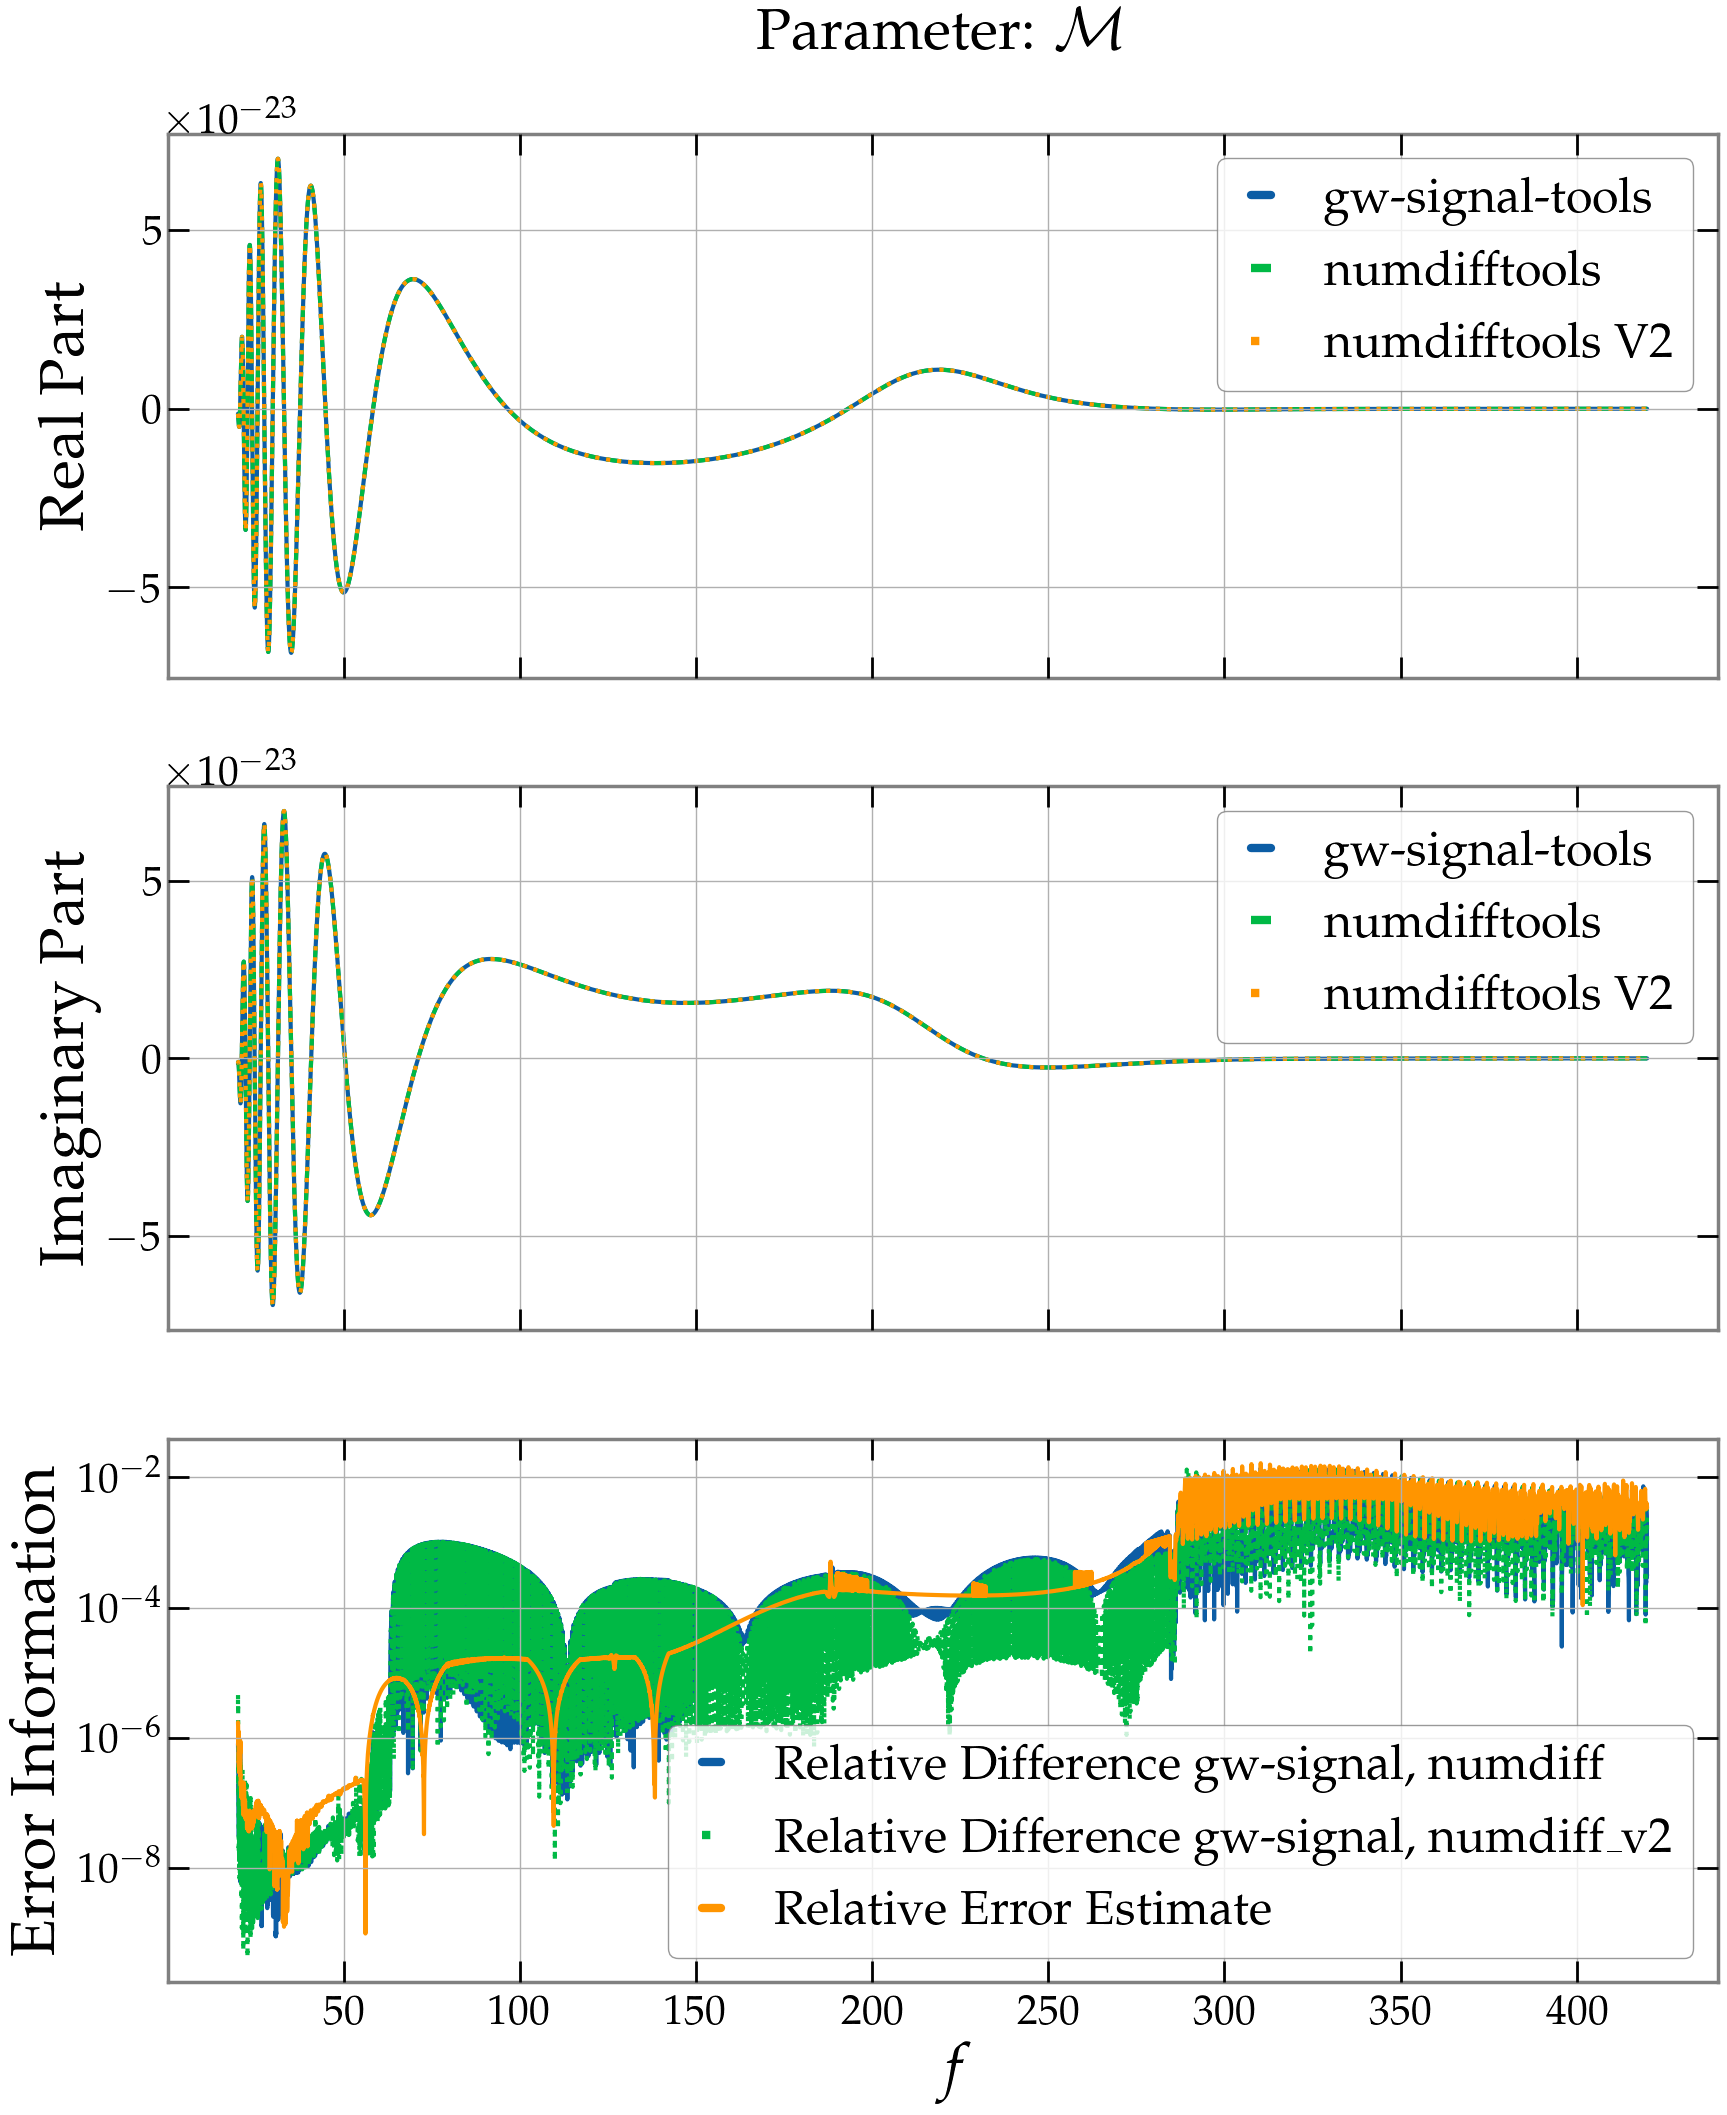

In [25]:
# f_range=[f_min, f_max]
# f_range=[f_min, 60. * u.Hz]
# f_range=[f_min, 200. * u.Hz]
f_range=[f_min, 420. * u.Hz]



fig, ax = plt.subplots(figsize=(20, 24), nrows=3, sharex=True)

ax[0,].plot(
    num_deriv_gw_signal.crop(start=f_range[0], end=f_range[1]).real,
    label='gw-signal-tools'
)
ax[0,].plot(
    num_deriv_nd_tools.crop(start=f_range[0], end=f_range[1]).real,
    '--',
    label='numdifftools'
)
ax[0,].plot(
    num_deriv_nd_tools_2.crop(start=f_range[0], end=f_range[1]).real,
    ':',
    label='numdifftools V2'
)


ax[1,].plot(
    num_deriv_gw_signal.crop(start=f_range[0], end=f_range[1]).imag,
    label='gw-signal-tools'
)
ax[1,].plot(
    num_deriv_nd_tools.crop(start=f_range[0], end=f_range[1]).imag,
    '--',
    label='numdifftools'
)
ax[1,].plot(
    num_deriv_nd_tools_2.crop(start=f_range[0], end=f_range[1]).imag,
    ':',
    label='numdifftools V2'
)


ax[2,].plot(
    ((num_deriv_gw_signal - num_deriv_nd_tools) / num_deriv_nd_tools).abs().crop(start=f_range[0], end=f_range[1]),
    label='Relative Difference gw-signal, numdiff'
)
ax[2,].plot(
    ((num_deriv_gw_signal - num_deriv_nd_tools_2) / num_deriv_nd_tools_2).abs().crop(start=f_range[0], end=f_range[1]),
    ':',
    label='Relative Difference gw-signal, numdiff_v2'
)

ax[2,].plot(
    (deriv_nd_tools.error_estimate / num_deriv_nd_tools).abs().crop(start=f_range[0], end=f_range[1]),
    label='Relative Error Estimate'
)


# title = param_to_vary
# title += f' ({par})' if ((par:=latexparams.get(param_to_vary, None)) is not None) else ''
# title += ' derivative'
title = f'Parameter: {latexparams.get(param_to_vary, param_to_vary)}'
# fig.suptitle(title)
ax[0,].set_title(title+'\n')

ax[0,].set_ylabel('Real Part')
ax[0,].legend()#(ncols=3)

ax[1,].set_ylabel('Imaginary Part')
ax[1,].legend()#(ncols=3)

ax[2,].set_xlabel('$f$')
ax[2,].set_yscale('log')
ax[2,].set_ylabel('Error Information')
ax[2,].legend()

plt.show()

Relative difference on scale of error estimate is good, right? Should mean we get equal to numdifftools result that we are on scale of its error, i.e. the deviation need not come from our own implementation

In [13]:
from gw_signal_tools.waveform import norm

In [14]:
f_range = None  # No restriction here

fisher1 = norm(num_deriv_gw_signal, f_range=f_range)
fisher2 = norm(num_deriv_nd_tools, f_range=f_range)

In [15]:
print(fisher1, fisher2, abs((fisher1 - fisher2) / fisher1))

9.55828243206657e-22 1 / solMass 9.55827807463475e-22 1 / solMass 4.558802118548807e-07


Agreement is good, only real deviations (around 1%) occur for extreme situations like very small symmetric mass ratio, otherwise usually around 1e-4 or even lower.

## Verification with Analytical Derivatives

### Phase and Time

In [16]:
waveform = wf_generator(wf_params)
ana_deriv_time = waveform * -1j * 2. * np.pi * waveform.frequencies
ana_deriv_phase = waveform * 2j

deriv_phase = WaveformDerivative(
    wf_params,
    'phi_ref',
    wf_generator
)

num_deriv_phase, info_dict_phase = deriv_phase(), deriv_phase.deriv_info

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

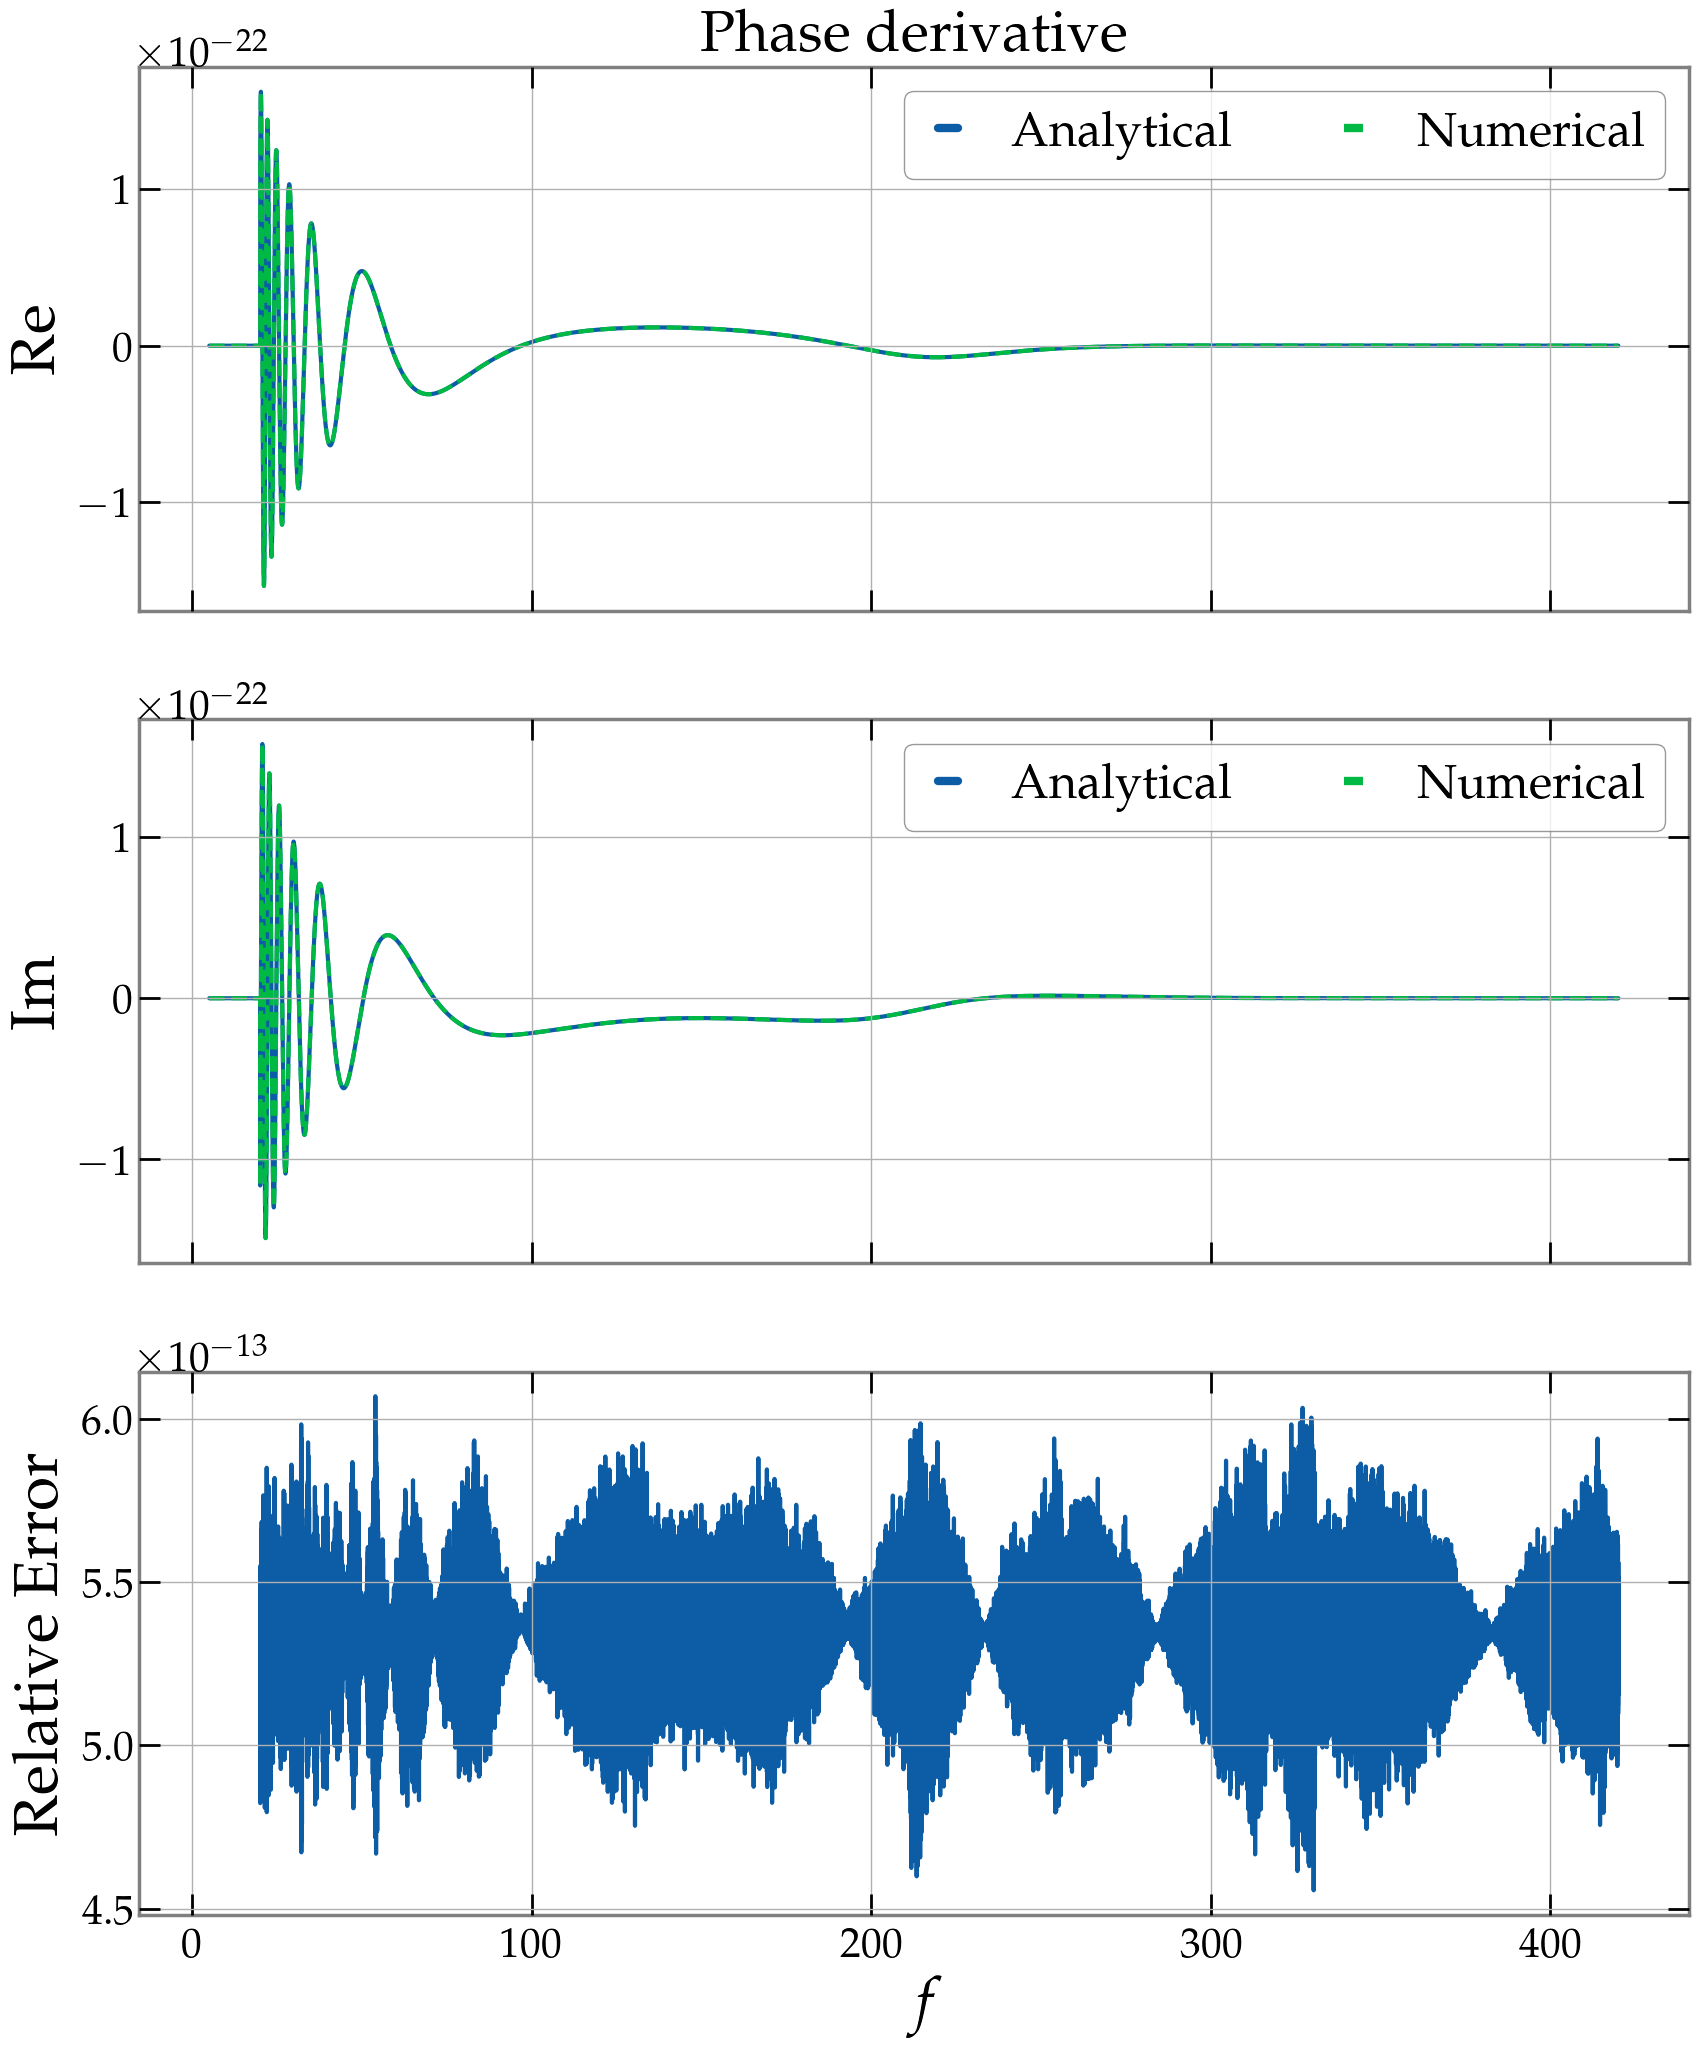

In [17]:
f_range=[5.*u.Hz, 420.*u.Hz]


fig, ax = plt.subplots(figsize=(20,24), nrows=3, sharex=True)

ax[0].plot(
    ana_deriv_phase.crop(start=f_range[0], end=f_range[1]).real,
    label='Analytical'
)
ax[0].plot(
    num_deriv_phase.crop(start=f_range[0], end=f_range[1]).real,
    '--',
    label='Numerical'
)


ax[1].plot(
    ana_deriv_phase.crop(start=f_range[0], end=f_range[1]).imag,
    label='Analytical'
)
ax[1].plot(
    num_deriv_phase.crop(start=f_range[0], end=f_range[1]).imag,
    '--',
    label='Numerical'
)


ax[2].plot(
    ((ana_deriv_phase - num_deriv_phase) / ana_deriv_phase).abs().crop(start=f_range[0], end=f_range[1])
)


ax[0].legend(ncols=2)
ax[1].legend(ncols=2)
ax[0].set_title('Phase derivative')
ax[0].set_ylabel('Re')
ax[1].set_ylabel('Im')
ax[2].set_ylabel('Relative Error')
plt.xlabel('$f$')
# plt.xlim(5, 100)

plt.show()

Very good agreement. Note, however, that this might not be the case if higher harmonics have a significant impact or if the binary is precessing.

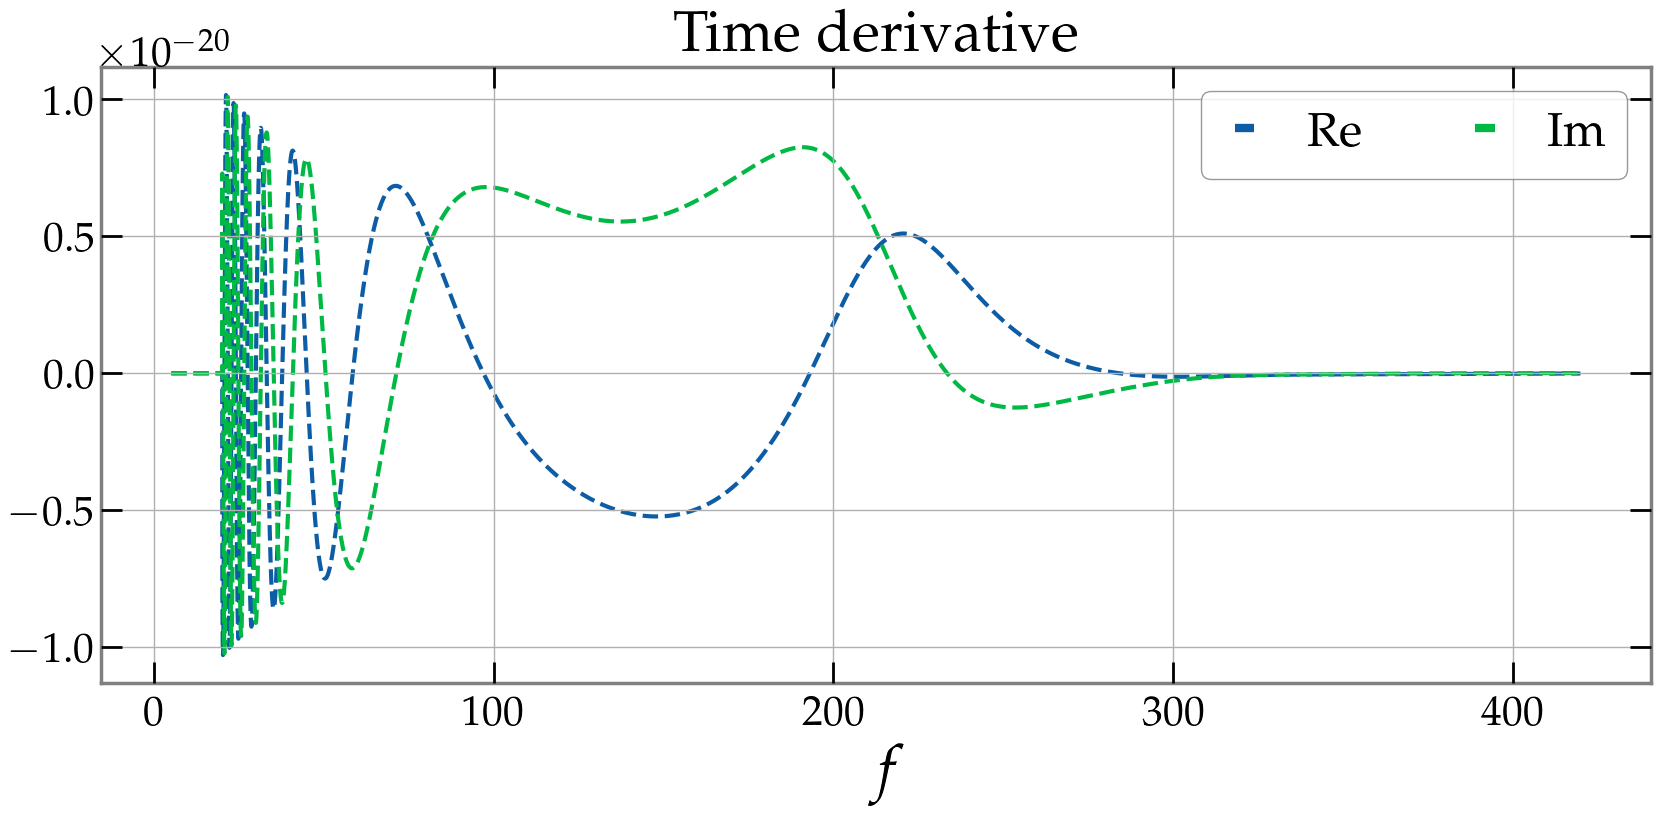

In [18]:
f_range=[5.*u.Hz, 420.*u.Hz]


fig, ax = plt.subplots(figsize=(20,8))

ax.plot(
    ana_deriv_time.crop(start=f_range[0], end=f_range[1]).real,
    '--',
    label='Re'
)
ax.plot(
    ana_deriv_time.crop(start=f_range[0], end=f_range[1]).imag,
    '--',
    label='Im'
)

ax.set_title('Time derivative')
ax.set_xlabel('$f$')
ax.legend(ncols=2)
# plt.xlim(5, 100)

plt.show()

### Luminosity Distance

For the distance, we can calculate a analytical derivative by noticing that

$$h(f, D_L) = h(f, 1) / D_L$$

which implies

$$\frac{\partial h(f, D_L)}{\partial D_L} = h(f, 1) \frac{\partial 1/D_L}{\partial D_L} = h(f, 1) (-1 / D_L^2) = - h(f, D_L) / D_L .$$

In [19]:
# We rename distance parameter in the new generator so that derivative
# routine does not recognize it and uses analytical derivative
def dist_deriv_gen(wf_params):
    _wf_params = wf_params.copy()
    _wf_params['distance'] = _wf_params.pop('dist')

    return wf_generator(_wf_params)

dist_deriv_params = wf_params.copy()
dist_deriv_params.pop('distance');
dist_deriv_params['dist'] = wf_params['distance']

deriv_distance = WaveformDerivative(
    dist_deriv_params,
    'dist',
    dist_deriv_gen
)

num_deriv_distance, info_dict_distance = deriv_distance(), deriv_distance.deriv_info

ana_deriv_distance = - wf_generator(wf_params) / wf_params['distance']

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


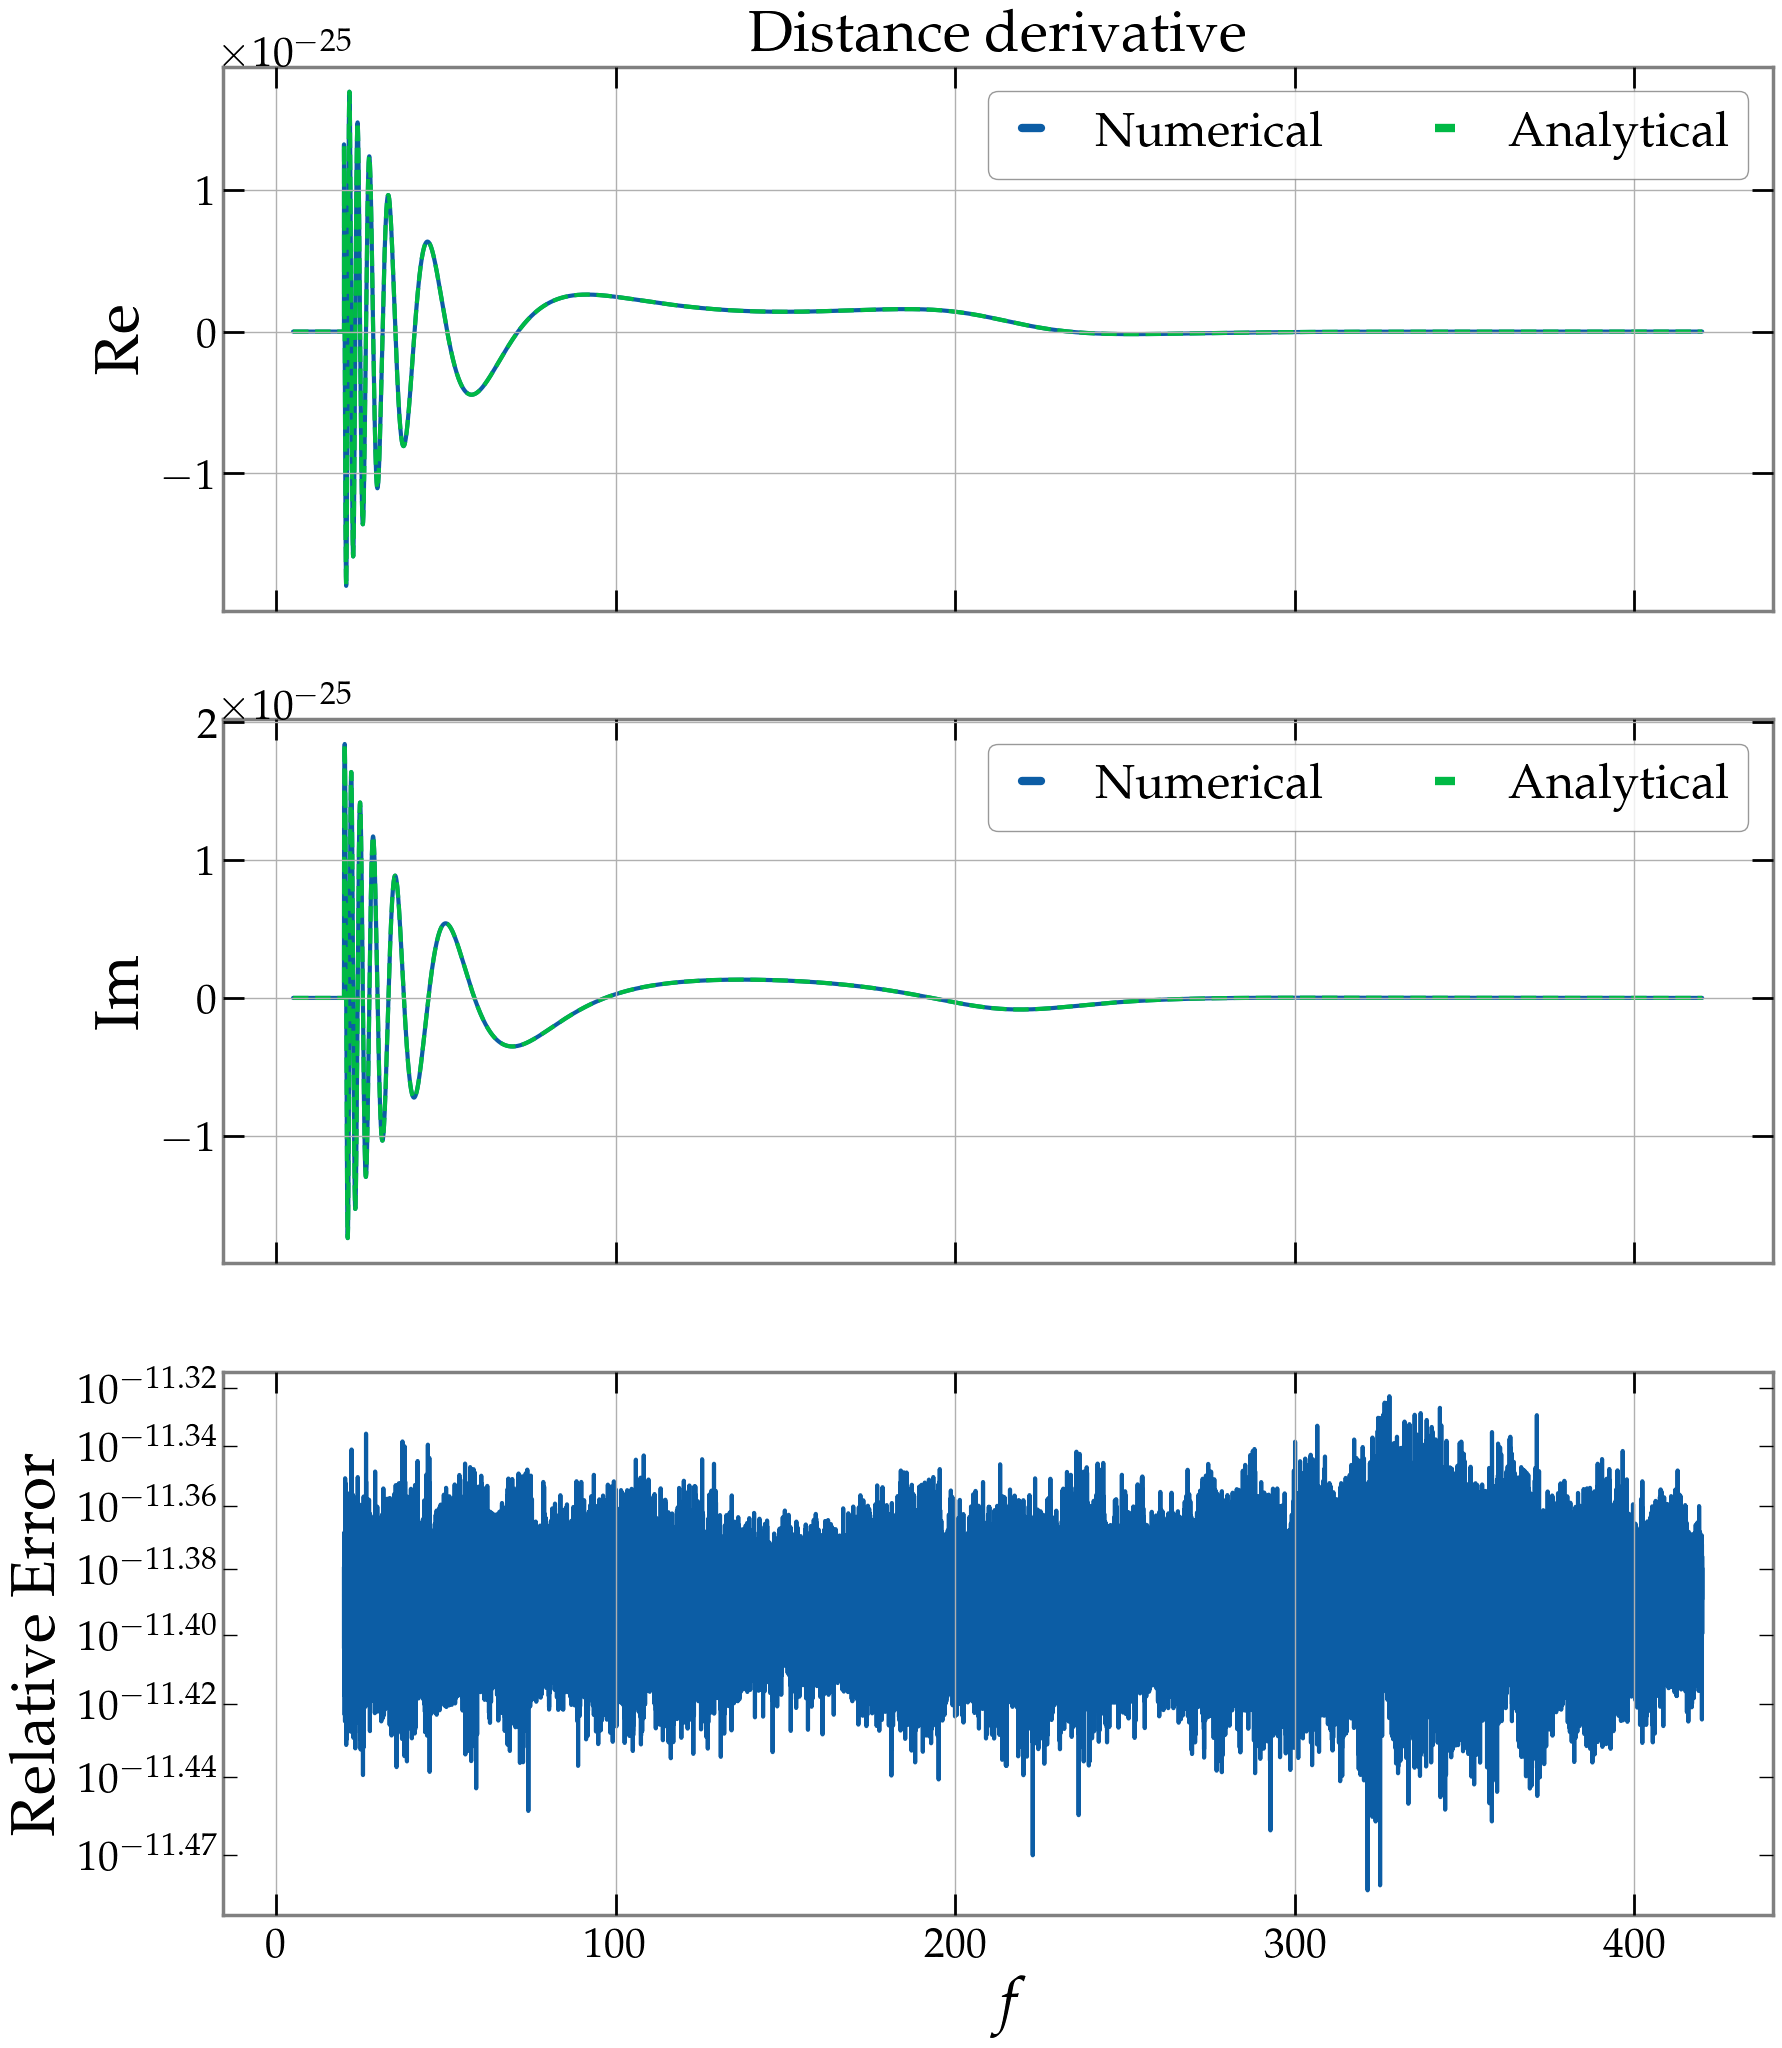

In [20]:
f_range=[5.*u.Hz, 420.*u.Hz]


fig, ax = plt.subplots(figsize=(20,24), nrows=3, sharex=True)

ax[0].plot(
    num_deriv_distance.crop(start=f_range[0], end=f_range[1]).real,
    label='Numerical'
)
ax[0].plot(
    ana_deriv_distance.crop(start=f_range[0], end=f_range[1]).real,
    '--',
    label='Analytical'
)


ax[1].plot(
    num_deriv_distance.crop(start=f_range[0], end=f_range[1]).imag,
    label='Numerical'
)
ax[1].plot(
    ana_deriv_distance.crop(start=f_range[0], end=f_range[1]).imag,
    '--',
    label='Analytical'
)


ax[2].plot(
    ((ana_deriv_distance - num_deriv_distance) / ana_deriv_distance).abs().crop(start=f_range[0], end=f_range[1])
)


ax[0].set_title('Distance derivative')
ax[0].legend(ncols=2)
ax[1].legend(ncols=2)
ax[2].set_yscale('log')
plt.xlabel('$f$')
ax[0].set_ylabel('Re')
ax[1].set_ylabel('Im')
ax[2].set_ylabel('Relative Error')
# plt.xlim(5, 100)

plt.show()

Very good agreement

## Benchmarking

In [21]:
import cProfile

In [22]:
cProfile.run(
    '''deriv = WaveformDerivative(
        wf_params,
        param_to_vary,
        wf_generator,
        deriv_routine='gw_signal_tools'
    ).deriv''',
    sort=1
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

         97011 function calls (96443 primitive calls) in 7.243 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       17    4.261    0.251    4.263    0.251 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
      323    1.262    0.004    1.262    0.004 {built-in method lal._lal.DictInsertREAL8Value}
       34    0.274    0.008    0.413    0.012 array.py:319(epoch)
       17    0.196    0.012    6.942    0.408 waveform.py:334(generate_fd_waveform)
       34    0.145    0.004    0.589    0.017 waveform.py:525(to_gwpy_Series)
       34    0.143    0.004    0.143    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedTDApproximants}
       34    0.139    0.004    0.139    0.004 _tconvert.py:97(to_gps)
       34    0.128    0.004    0.128    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedFDApproximants}
       17    0.076    0.004    1.686    0.099 wavef

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

Main contributor is waveform generation, which is expected and also fine (cannot be avoided).

In [23]:
cProfile.run(
    '''deriv = WaveformDerivative(
        wf_params,
        param_to_vary,
        wf_generator,
        deriv_routine='numdifftools'
    ).deriv''',
    sort=1
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

         3263136 function calls (3262488 primitive calls) in 16.053 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       32    7.752    0.242    7.756    0.242 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
      608    2.430    0.004    2.430    0.004 {built-in method lal._lal.DictInsertREAL8Value}
        1    0.702    0.702    1.753    1.753 limits.py:143(_get_arg_min)
       64    0.509    0.008    0.769    0.012 array.py:319(epoch)
        1    0.411    0.411    0.482    0.482 extrapolation.py:378(dea3)
       32    0.396    0.012   12.866    0.402 waveform.py:334(generate_fd_waveform)
   262145    0.311    0.000    1.006    0.000 numeric.py:615(flatnonzero)
       64    0.264    0.004    0.264    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedFDApproximants}
       64    0.259    0.004    0.259    0.004 _tconvert.py:97(to_gps)
       64    0.258    0.004    0.

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

In [24]:
cProfile.run(
    '''deriv = WaveformDerivative(
        wf_params,
        param_to_vary,
        wf_generator,
        deriv_routine='amplitude_phase'
    ).deriv''',
    sort=1
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

         6511774 function calls (6510575 primitive calls) in 30.739 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       63   15.497    0.246   15.506    0.246 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
     1197    4.859    0.004    4.859    0.004 {built-in method lal._lal.DictInsertREAL8Value}
        2    1.478    0.739    3.657    1.828 limits.py:143(_get_arg_min)
      126    0.933    0.007    1.415    0.011 array.py:319(epoch)
       63    0.717    0.011   25.273    0.401 waveform.py:334(generate_fd_waveform)
   524290    0.640    0.000    2.084    0.000 numeric.py:615(flatnonzero)
      126    0.514    0.004    0.514    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedTDApproximants}
      126    0.482    0.004    0.482    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedFDApproximants}
      126    0.482    0.004    0.483    0.004 

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupChirpMass (LALSimInspiralWaveformParams.c:887): This code is

We clearly difference in waveform calls, which causes difference in runtime. Is because we have to calculate amplitude and phase separately.